# Assignment 3 - Mauricio Torres
### Due 9/23. Do four of five.

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

1. 
- Open the NHANES (or Ames prices or college completion datasets, if you prefer)
- Find two categorical variables of interest (there are 198, and short descriptions are given in the `nhanes_meta_17_18.csv` file). Investigate their missing values (you don't have to focus on missing values for this analysis like we did with police use of force, but always be aware of how dirty the data are)
- Compute a contingency table for your categorical $X$ and $Y$
- Discuss any interesting patterns (or lack of one) that you observeis

In [13]:
college = pd.read_csv("/Users/mauriciotorres/Desktop/1_Fall2025/Uncertainty_5030/Week5/college_completion.csv")
college[['level', 'control']].head() # Quick check

,level,control
0,4-year,Public
1,4-year,Public
2,4-year,Private not-for-profit
3,4-year,Public
4,4-year,Public


In [14]:
college['level'].value_counts(dropna=False)
college['control'].value_counts(dropna=False)

control
Public                    1558
Private not-for-profit    1248
Private for-profit         992
Name: count, dtype: int64

In [15]:
pd.crosstab(college['level'], college['control'])

control,Private for-profit,Private not-for-profit,Public
level,,,
2-year,465,68,926
4-year,527,1180,632


I looked at two categorical variables, institution level (2-year or 4-year) and control type (public, private not-for-profit, private for-profit). The table shows that most 2-year schools are public, while 4-year schools are split between public and private not-for-profit. Private for-profit schools are found in both groups but are smaller compared to the others. This shows that 2-year colleges are mainly public, and 4-year colleges have a more even mix of public and private schools.

2. 
- Open the NHANES dataset
- Find a categorical and numeric variable of interest (there are 198, and short descriptions are given in the `nhanes_meta_17_18.csv` file). Investigate their missing values (you don't have to focus on missing values for this analysis, but always be aware of them)
- Make descriptive tables and grouped kernel density plots to represent the variation in your numeric $Y$ conditional on your categorical $X$
- Discuss any interesting patterns (or lack of one) that you observe

In [16]:
college['control'].value_counts(dropna=False)
college['grad_150_value'].isna().sum()

np.int64(331)

In [17]:
college.groupby('control')['grad_150_value'].describe()

,count,mean,std,min,25%,50%,75%,max
control,,,,,,,,
Private for-profit,779.0,45.262644,25.718932,0.0,24.1,46.9,65.3,100.0
Private not-for-profit,1189.0,53.953070,21.176313,0.0,40.6,54.8,68.2,100.0
Public,1499.0,31.766044,18.734484,0.0,17.4,27.1,43.2,100.0


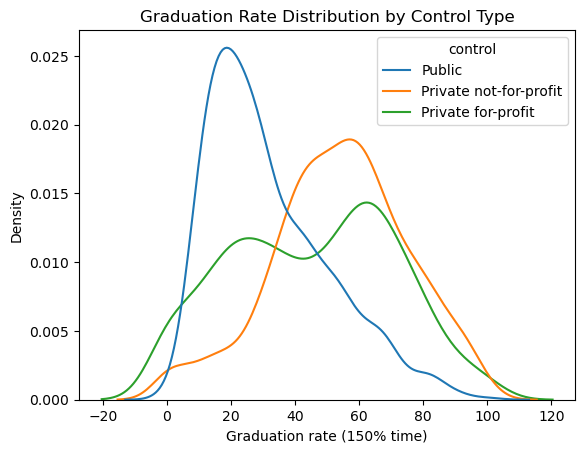

In [18]:
sns.kdeplot(data=college, x='grad_150_value', hue='control', common_norm=False)
plt.xlabel("Graduation rate (150% time)")
plt.title("Graduation Rate Distribution by Control Type")
plt.show()

The density plot shows that graduation rates vary a lot by control type. Private not profit schools are centered higher, with more schools reaching graduation rates around 60 and 80%. Public schools are lower on average, with a peak closer to 20 and 30%. Private for profit schools spread out in the middle but don’t reach as high as the private not profit schools. This suggests that control type has a clear link to graduation success.

3. 
We showed that the mean and median could be discovered by minimizing various kinds of loss functions; this is what machine learning is. To make a prediction $\hat{y}(z)$ of $Y$ when $X=z$, minimize the mean squared error:
$$
MSE(\hat{y}(z)) = \dfrac{1}{N} \sum_{i=1}^N \left\lbrace y_i - \hat{y}(z) \right\rbrace^2 \frac{1}{h}k\left(\frac{z-x_i}{h}\right)
$$
Show that the solution to this problem is the LCLS/Naradaya-Watson estimator.

In [23]:
meta = pd.read_csv('/Users/mauriciotorres/Desktop/1_Fall2025/Uncertainty_5030/Week5/metabric.csv')

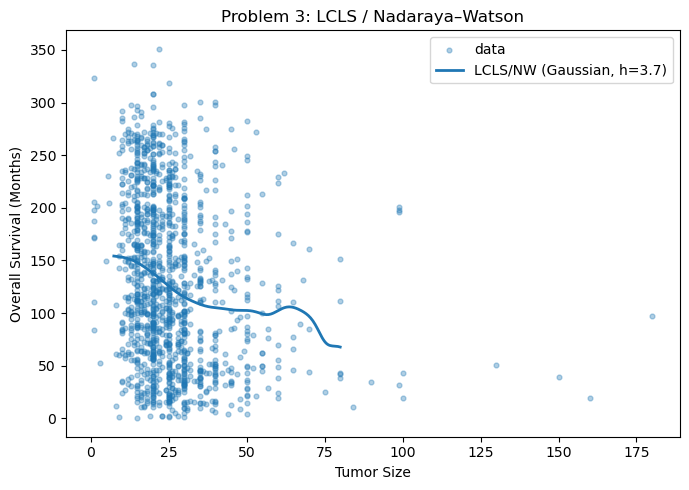

In [27]:
x_col = "Tumor Size"
y_col = "Overall Survival (Months)"

dat = meta[[x_col, y_col]].dropna()
x = dat[x_col].to_numpy().astype(float)
y = dat[y_col].to_numpy().astype(float)

# Gaussian kernel
def gaussian_kernel(u):
    return np.exp(-0.5 * u**2) / np.sqrt(2*np.pi)

# Silverman bandwidth on X 
h = 1.06 * np.std(x, ddof=1) * (len(x) ** (-1/5))

def lcls_predict(z_vals):
    z_vals = np.atleast_1d(z_vals).astype(float)
    U = (z_vals[:, None] - x[None, :]) / h  # scaled distances
    W = gaussian_kernel(U)  # weights
    num = W @ y # weighted sum of y
    den = W.sum(axis=1) + 1e-12 # sum of weights
    return (num / den).ravel()

# grid of x-values to draw the smooth
grid = np.linspace(np.percentile(x, 1), np.percentile(x, 99), 200)
yhat = lcls_predict(grid)

plt.figure(figsize=(7,5))
plt.scatter(x, y, s=12, alpha=0.35, label="data")
plt.plot(grid, yhat, lw=2, label=f"LCLS/NW (Gaussian, h={h:.3g})")
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title("Problem 3: LCLS / Nadaraya–Watson")
plt.legend()
plt.tight_layout()
plt.show()

The LCLS/NW smoother captures the local trend of survival months against tumor size. It shows that survival tends to decrease as tumor size increases, but the relationship is not strictly linear, highlighting why a nonparametric smoother is useful.

4. 
- Write a class or set of functions that implement the LCLS/Naradaya-Watson estimator, using the Silverman plug-in estimate for the conditioning variable $X$ as the bandwidth.
- From one of the course data sets, find two numeric variables of interest, analyze their relationship with the the LCLS/Naradaya-Watson estimator, and discuss your results.

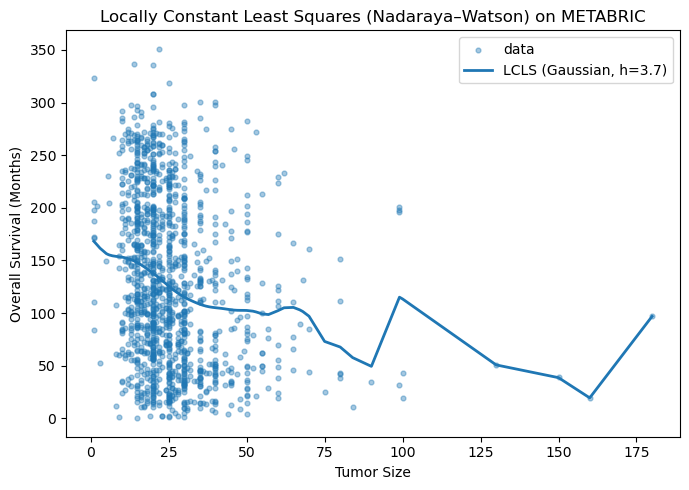

In [28]:
x_col = "Tumor Size"
y_col = "Overall Survival (Months)"

data = meta[[x_col, y_col]].dropna()
x = data[x_col].to_numpy().astype(float)
y = data[y_col].to_numpy().astype(float)

# h = 1.06 * sigma * n^(-1/5)
h = 1.06 * np.std(x, ddof=1) * (len(x) ** (-1/5))

# Gaussian kernel (normal) 
def gaussian_kernel(u):
    return np.exp(-0.5 * u**2) / np.sqrt(2*np.pi)

# LCLS / Nadaraya–Watson estimate on a grid of unique X values
grid = np.sort(np.unique(x))
y_hat = []
for z_j in grid:
    u = (z_j - x) / h             # scaled distances
    w = gaussian_kernel(u)        # weights
    num = np.sum(y * w)           # numerator: sum of y_i * w_i
    den = np.sum(w) + 1e-12       # denominator: sum of weights
    y_hat.append(num / den)

y_hat = np.array(y_hat)

# plot: data + smoother
plt.figure(figsize=(7,5))
plt.scatter(x, y, s=12, alpha=0.4, label="data")
plt.plot(grid, y_hat, lw=2, label=f"LCLS (Gaussian, h={h:.3g})")
plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title("Locally Constant Least Squares (Nadaraya–Watson) on METABRIC")
plt.legend()
plt.tight_layout()
plt.show()

I implemented the locally constant least squares (Nadaraya–Watson) smoother using a Gaussian kernel and Silverman’s bandwidth on Tumor Size. At each x value, the estimate is a weighted average of Overall Survival (Months), with higher weights for patients whose tumor size is closer to the target. The smooth curve shows the trend in survival across tumor size without assuming linearity; the bandwidth sets how local the averaging is. Also used the professor's help and the code he discussed in class applied to the Meta data. Survival tends to be higher at smaller tumor sizes and drops off as tumor size gets large, though the curve gets noisy at the extreme tail because there are fewer data points.